# Table of Contents

* [Import and downsampling data](#Import-and-downsampling-data)
* [Function to log results](#Function-to-log-results)
* [Function to print metrics on training data](#Function-to-print-metrics-on-training-data)
* [Modeling](#Modeling)
    * [1. Random Forest](#1.-Random-Forest)
    * [2. XGboost](#2.-XGboost )
    * [3. LightGBM](#3.-LightGBM)
    * [4. Logistic Regression with regularizations](#4.-Logistic-Regression-with-regularizations)
    * [5. KNN](#5.-KNN)      
    * [6. SVM](#6.-SVM)
* [Summary](#Summary)

In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install xgboost
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
%matplotlib inline  
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve

## Import and downsampling data

Use the code below to create a balanced training dataset to be used by all ML models that we build shortly. Test sets are still imbalanced.

In [2]:
from sklearn.model_selection import train_test_split

data_all = pd.read_csv('sm_data.csv')
X = data_all.iloc[:,1:]
y = data_all['TARGET']

# train test split using test_size = 0.2 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

X_train_0 = X_train.loc[y_train == 0,:].copy().sample(frac = 0.09)
X_train_1 = X_train.loc[y_train == 1,:].copy()

X_train_0['target'] = 0
X_train_1['target'] = 1

# use frac = 1 to randomize the rows
X_train_new = X_train_0.append(X_train_1).sample(frac = 1)

X_train_new_x = X_train_new.drop(columns='target')
y_train_new = X_train_new['target']

In [3]:
print("X train shape: ", X_train_new_x.shape)
print("y train shape: ", y_train_new.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (40209, 350)
y train shape:  (40209,)
X test shape:  (61501, 350)
y test shape:  (61501,)


Save X_train_new_x, y_train_new, X_test and y_test for future model evaluations

In [ ]:
X_train_new_x.to_csv("X_train_new_x.csv", index=False)
y_train_new.to_csv("y_train_new.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

## Function to log results

In [4]:
def model_log(cv_clf, modelname):
    rlt_dict = {}

    rlt_dict['best_estimator_'] = [cv_clf.best_estimator_]
    rlt_dict['best_params_'] = [cv_clf.best_params_]
    rlt_dict['best_score_'] = [cv_clf.best_score_]
    rlt_dict['best_index_'] = [cv_clf.best_index_]

    rlt_dict['candidate_params'] = [cv_clf.cv_results_['params']]
    rlt_dict['mean_test_score'] = [cv_clf.cv_results_['mean_test_score']]
    rlt_dict['std_test_score'] = [cv_clf.cv_results_['std_test_score']]
    rlt_dict['mean_train_score'] = [cv_clf.cv_results_['mean_train_score']]
    rlt_dict['std_train_score'] = [cv_clf.cv_results_['std_train_score']]

    rlt_dict['split0_test_score'] = [cv_clf.cv_results_['split0_test_score']]
    rlt_dict['split1_test_score'] = [cv_clf.cv_results_['split1_test_score']]
    rlt_dict['split2_test_score'] = [cv_clf.cv_results_['split2_test_score']]
    rlt_dict['split3_test_score'] = [cv_clf.cv_results_['split3_test_score']]
    rlt_dict['split4_test_score'] = [cv_clf.cv_results_['split4_test_score']]

    rlt_dict['split0_train_score'] = [cv_clf.cv_results_['split0_train_score']]
    rlt_dict['split1_train_score'] = [cv_clf.cv_results_['split1_train_score']]
    rlt_dict['split2_train_score'] = [cv_clf.cv_results_['split2_train_score']]
    rlt_dict['split3_train_score'] = [cv_clf.cv_results_['split3_train_score']]
    rlt_dict['split4_train_score'] = [cv_clf.cv_results_['split4_train_score']]

    rlt_df = pd.DataFrame.from_dict(rlt_dict)
    
    filename = modelname + '_' + 'cv_rlt.csv'
    rlt_df.to_csv(filename)

## Function to print metrics on training data

In [5]:
def print_report(modelname):
    filename = modelname + '_' + 'metrics.csv'
    metrics = pd.read_csv(filename)
    confusion_matrix = metrics['confusion_matrix'].values[0]
    accuracy = metrics['accuracy'].values[0]
    auc = metrics['auc'].values[0]
    f1_0 = ast.literal_eval(metrics['class_0'].values[0])['f1-score']
    f1_1 = ast.literal_eval(metrics['class_1'].values[0])['f1-score']
    weighted_avg_f1 = ast.literal_eval(metrics['weighted avg'].values[0])['f1-score']

    print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
    print("2. Training accuracy: %f" % (accuracy))
    print("3. Training AUC: ", auc)
    print("4. F1 score for non-default group in the training data: ", f1_0)
    print("5. F1 score for default group in the training data: ", f1_1)
    print("6. Weighted F1 score for the training data: ", weighted_avg_f1)

## Modeling

The first 3 models we build are tree based. Since tree based models are robust regardless of the skewed distributions of the features, we do not need to scale the features. Later on when we train other classification models that are more sensitive to the scale of features, such as logistic regression, KNN and SVM, we first transform some of the features before fitting the models.

## 1. Random Forest

In [ ]:
import time
start = time.clock()

#when max depth is large (eg. 20), it's obvious that the RF model is overfitting 
#(CV training score 97%, test score 66%)

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'max_depth': range(1,10)} 

clf = RandomForestClassifier(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', verbose=verbose, n_jobs=-1) 
cv_clf.fit(X_train_new_x, y_train_new)

print('completed in {} s'.format(time.clock() - start))

# write out results
model_log(cv_clf, 'randomforest')

In [6]:
import re
import ast
result = pd.read_csv('randomforest_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
print("2. Best number of trees and depth are: {} and {}".format(best_n, best_d))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 400, 'max_depth': 1}, {'n_estimators': 200, 'max_depth': 5}, {'n_estimators': 200, 'max_depth': 6}, {'n_estimators': 400, 'max_depth': 5}, {'n_estimators': 400, 'max_depth': 4}]
2. Best number of trees and depth are: 200 and 6
3. Best average CV validation score is:  0.6810664279141486
4. Average CV validation score:  [0.6466214  0.67686339 0.68106643 0.67676391 0.67360541]
5. Standard Deviation of CV validation score:  [0.0086146  0.00438749 0.00343502 0.00395083 0.00445787]
6. Average CV training score:  [0.6494628  0.69391182 0.70619763 0.69428487 0.68429954]
7. Standard Deviation of CV training score:  [0.00210377 0.00123042 0.00212855 0.00084375 0.00097449]
1st fold validation score:  [0.63918936 0.6695263  0.67760786 0.67064528 0.66654233]
2nd fold validation score:  [0.63827406 0.67980602 0.67980602 0.67918428 0.67309127]
3rd fold validation score:  [0.64399403 0.67781646 0.68353643 0.67744342 0.67520517]
4th fold validation s

In [ ]:
preds = cv_clf.predict(X_train_new_x)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)
probs = cv_clf.predict_proba(X_train_new_x)
auc = roc_auc_score(y_train_new, probs[:,1])
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('randomforest_metrics.csv')

Print the report on the entire training data

In [7]:
print_report('randomforest')

1. Confusion Matrix for the training data is: 
 [[14794  5559]
 [ 6434 13422]]
2. Training accuracy: 0.701733
3. Training AUC:  0.7697733933423979
4. F1 score for non-default group in the training data:  0.7115749981962916
5. F1 score for default group in the training data:  0.6911965393825475
6. Weighted F1 score for the training data:  0.7015117119119845


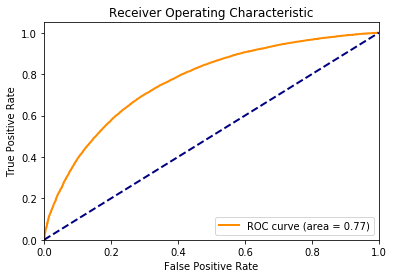

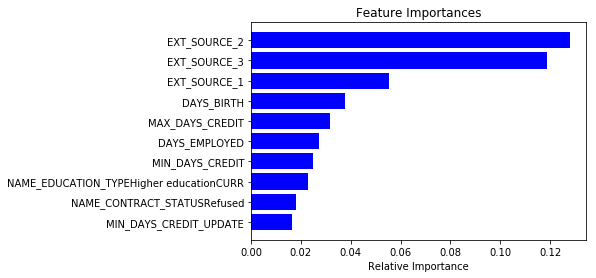

In [14]:
result = pd.read_csv('randomforest_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']

clf = RandomForestClassifier(n_estimators = best_n, max_depth = best_d, 
                             bootstrap=True, class_weight=None, criterion='gini',
                             max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_jobs=None,
                             oob_score=False, random_state=123, verbose=0, warm_start=False)

clf.fit(X_train_new_x, y_train_new)

preds = clf.predict(X_train_new_x)
probs = clf.predict_proba(X_train_new_x)

# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# plot top 10 features of the training set
M = 10
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_new_x.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()

## 2. XGboost 

In [ ]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,10), 'gamma': [0.001,0.01,1,10]}
               
clf = XGBClassifier(objective='binary:logistic', verbosity=verbose, booster='gbtree', tree_method='auto', 
                            subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', verbose=verbose, n_jobs=-1)
cv_clf.fit(X_train_new_x, y_train_new)

print('completed in {} s'.format(time.clock() - start))

# write out results
model_log(cv_clf, 'xgboost')

In [15]:
import re
import ast
result = pd.read_csv('xgboost_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']
best_gamma = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['gamma']
print("2. Best number of trees, learning rate, depth and gamma are: {}, {}, {} and {}".format(best_n, best_lr, best_d, best_gamma))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.5, 'gamma': 1}, {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.01}, {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 1}, {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.01}, {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.001}]
2. Best number of trees, learning rate, depth and gamma are: 300, 0.1, 3 and 0.001
3. Best average CV validation score is:  0.7073540749583427
4. Average CV validation score:  [0.69929618 0.70362357 0.69019374 0.67987267 0.70735407]
5. Standard Deviation of CV validation score:  [0.00591636 0.00419497 0.00322462 0.00430646 0.00349034]
6. Average CV training score:  [0.74533065 0.88148797 0.82054391 1.         0.74600217]
7. Standard Deviation of CV training score:  [0.00200899 0.00268507 0.00137744 0.         0.00166425]
1st fold validation score:  [0.68966803 0.69650628 0.68643541 

In [ ]:
preds = cv_clf.predict(X_train_new_x)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)
probs = cv_clf.predict_proba(X_train_new_x)
auc = roc_auc_score(y_train_new, probs[:,1])
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('xgboost_metrics.csv')

Print the report on the entire training data

In [16]:
print_report('xgboost')

1. Confusion Matrix for the training data is: 
 [[15236  5117]
 [ 5304 14552]]
2. Training accuracy: 0.740829
3. Training AUC:  0.8167786654290691
4. F1 score for non-default group in the training data:  0.7451642090333308
5. F1 score for default group in the training data:  0.7363440860215054
6. Weighted F1 score for the training data:  0.7408086577258423


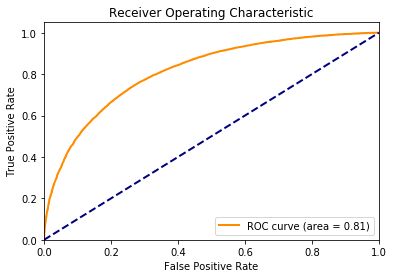

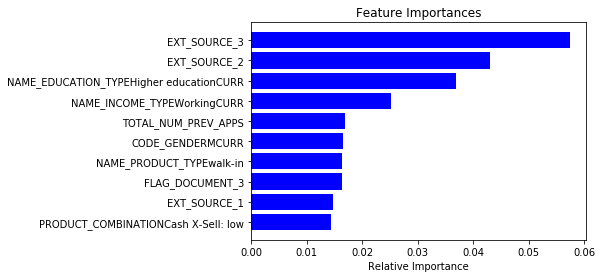

In [17]:
result = pd.read_csv('xgboost_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']
best_gamma = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['gamma']

clf = XGBClassifier(n_estimators = best_n, learning_rate = best_lr, max_depth = best_d, 
                            gamma = best_gamma, objective='binary:logistic', booster='gbtree', tree_method='auto', 
                            subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                            random_state = 123)
clf.fit(X_train_new_x, y_train_new)

preds = clf.predict(X_train_new_x)
probs = clf.predict_proba(X_train_new_x)

# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# plot top 10 features of the training set
M = 10
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_new_x.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()

## 3. LightGBM

In [ ]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,5)}

clf = LGBMClassifier(colsample_bytree=1, subsample=1, reg_alpha=0, reg_lambda=1, verbose=verbose)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1)  
cv_clf.fit(X_train_new_x, y_train_new)

print('completed in {} s'.format(time.clock() - start))

# write out results
model_log(cv_clf, 'lightgbm')

In [18]:
import re
import ast
result = pd.read_csv('lightgbm_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']
print("2. Best number of trees, learning rate and depth are: {}, {} and {}".format(best_n, best_lr, best_d))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}, {'n_estimators': 400, 'max_depth': 1, 'learning_rate': 0.01}, {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1}, {'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.5}]
2. Best number of trees, learning rate and depth are: 400, 0.1 and 3
3. Best average CV validation score is:  0.7077768658757989
4. Average CV validation score:  [0.70777687 0.68502077 0.66345843 0.70153448 0.70113656]
5. Standard Deviation of CV validation score:  [0.0048596  0.00250395 0.00196091 0.004046   0.00562005]
6. Average CV training score:  [0.75340097 0.69401127 0.66440971 0.71316121 0.71107212]
7. Standard Deviation of CV training score:  [0.00129703 0.00179467 0.00111364 0.00160364 0.00143365]
1st fold validation score:  [0.71590203 0.68929504 0.66666667 0.70806913 0.70719881]
2nd fold validation score:  [0.71089281 0.68515295 0.663392

In [ ]:
preds = cv_clf.predict(X_train_new_x)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)
probs = cv_clf.predict_proba(X_train_new_x)
auc = roc_auc_score(y_train_new, probs[:,1])
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('lightgbm_metrics.csv')

Print the report on the entire training data

In [19]:
print_report('lightgbm')

1. Confusion Matrix for the training data is: 
 [[15327  5026]
 [ 5167 14689]]
2. Training accuracy: 0.746500
3. Training AUC:  0.8244740404384768
4. F1 score for non-default group in the training data:  0.7504590300389257
5. F1 score for default group in the training data:  0.7424123726971772
6. Weighted F1 score for the training data:  0.7464854313874358


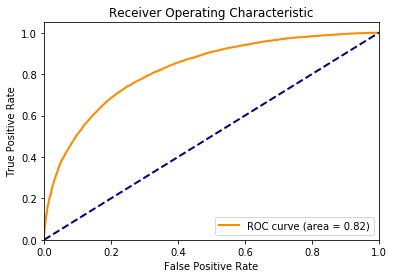

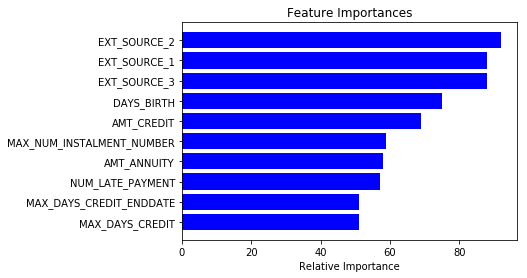

In [20]:
result = pd.read_csv('lightgbm_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']

clf = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, max_depth=best_d, 
                     boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                     importance_type='split', min_child_samples=20, min_child_weight=0.001, 
                     min_split_gain=0.0, n_jobs=-1, num_leaves=31, objective=None, random_state=None, 
                     reg_alpha=0, reg_lambda=1, silent=True, subsample=1, subsample_for_bin=200000, 
                     subsample_freq=0, verbose=0)

clf.fit(X_train_new_x, y_train_new)

preds = clf.predict(X_train_new_x)
probs = clf.predict_proba(X_train_new_x)

# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# plot top 10 features of the training set
M = 10
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_new_x.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()

## 4. Logistic Regression with regularizations

In [ ]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'penalty': ['l1','l2'], 'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10, 100]}
        
clf = LogisticRegression(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1) 
cv_clf.fit(X_train_new_x, y_train_new)

print('completed in {} s'.format(time.clock() - start))

# write out results
model_log(cv_clf, 'logistic')

In [21]:
import re
import ast
result = pd.read_csv('logistic_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']
print("2. Best C and penalty are: {} and {}".format(best_c, best_penalty))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'penalty': 'l1', 'C': 0.0005}, {'penalty': 'l2', 'C': 100}, {'penalty': 'l2', 'C': 0.1}, {'penalty': 'l1', 'C': 0.01}, {'penalty': 'l1', 'C': 100}]
2. Best C and penalty are: 100 and l1
3. Best average CV validation score is:  0.6985500758536646
4. Average CV validation score:  [0.62565595 0.61869233 0.61859285 0.69350145 0.69855008]
5. Standard Deviation of CV validation score:  [0.00548253 0.00579562 0.0044255  0.00465666 0.0068666 ]
6. Average CV training score:  [0.62744039 0.61969956 0.62020944 0.69645478 0.70543286]
7. Standard Deviation of CV training score:  [0.00117508 0.00076056 0.00180525 0.00098584 0.0016765 ]
1st fold validation score:  [0.61830163 0.60872809 0.61059306 0.68581375 0.68979237]
2nd fold validation score:  [0.62770455 0.6209898  0.62285501 0.6984581  0.7003233 ]
3rd fold validation score:  [0.62148719 0.61626461 0.61713504 0.6982094  0.70940065]
4th fold validation score:  [0.63424947 0.62554409 0.62144012 0.69195374 0.700

In [ ]:
preds = cv_clf.predict(X_train_new_x)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)
probs = cv_clf.predict_proba(X_train_new_x)
auc = roc_auc_score(y_train_new, probs[:,1])
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('logistic_metrics.csv')

Print the report on the entire training data

In [22]:
print_report('logistic')

1. Confusion Matrix for the training data is: 
 [[14531  5822]
 [ 6050 13806]]
2. Training accuracy: 0.704743
3. Training AUC:  0.7721142958926439
4. F1 score for non-default group in the training data:  0.7099721502907119
5. F1 score for default group in the training data:  0.6993212440482222
6. Weighted F1 score for the training data:  0.7047125219898123


/Users/lisalb168/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


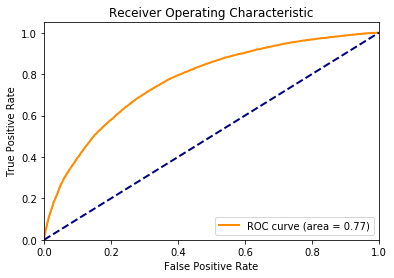

In [23]:
result = pd.read_csv('logistic_cv_rlt.csv')
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']

clf = LogisticRegression(C=best_c, class_weight=None, dual=False, fit_intercept=True,
                         intercept_scaling=1, max_iter=100, multi_class='warn',
                         n_jobs=None, penalty=best_penalty, random_state=123, solver='warn',
                         tol=0.0001, verbose=0, warm_start=False)

clf.fit(X_train_new_x, y_train_new)

preds = clf.predict(X_train_new_x)
probs = clf.predict_proba(X_train_new_x)

# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 5. KNN

In [ ]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_neighbors': range(1,20)}

clf = KNeighborsClassifier()
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1)
cv_clf.fit(X_train_new_x, y_train_new)

print('completed in {} s'.format(time.clock() - start))

# write out results
model_log(cv_clf, 'knn')

In [24]:
import re
import ast
result = pd.read_csv('knn_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_k = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_neighbors']
print("2. Best number of neighbors is: {}".format(best_k))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_neighbors': 1}, {'n_neighbors': 8}, {'n_neighbors': 13}, {'n_neighbors': 11}, {'n_neighbors': 15}]
2. Best number of neighbors is: 15
3. Best average CV validation score is:  0.5600984854137133
4. Average CV validation score:  [0.53316422 0.55258773 0.55781044 0.55674103 0.56009849]
5. Standard Deviation of CV validation score:  [0.00440273 0.00284203 0.00495116 0.00349181 0.00440329]
6. Average CV training score:  [1.         0.66470192 0.64433959 0.65318086 0.63793552]
7. Standard Deviation of CV training score:  [0.         0.00096835 0.00116557 0.0014774  0.00129869]
1st fold validation score:  [0.53562104 0.54917319 0.55775208 0.55576278 0.55924406]
2nd fold validation score:  [0.53233027 0.55595623 0.56080577 0.56229794 0.56366575]
3rd fold validation score:  [0.53456852 0.55583188 0.55894056 0.55844317 0.55856752]
4th fold validation score:  [0.53811715 0.5519214  0.56298968 0.55540356 0.56585002]
5th fold validation score:  [0.52518343 0.

In [ ]:
preds = cv_clf.predict(X_train_new_x)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)
probs = cv_clf.predict_proba(X_train_new_x)
auc = roc_auc_score(y_train_new, probs[:,1])
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('knn_metrics.csv')

Print the report on the entire training data

In [25]:
print_report('knn')

1. Confusion Matrix for the training data is: 
 [[13202  7151]
 [ 7346 12510]]
2. Training accuracy: 0.639459
3. Training AUC:  0.6905650608718249
4. F1 score for non-default group in the training data:  0.6455587882936847
5. F1 score for default group in the training data:  0.633145228635777
6. Weighted F1 score for the training data:  0.6394287268505398


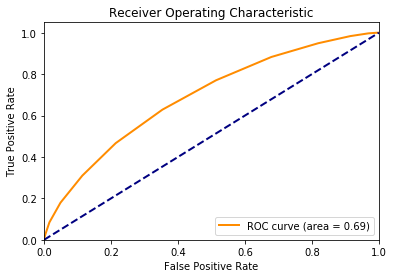

In [26]:
result = pd.read_csv('knn_cv_rlt.csv')
best_k = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_neighbors']

clf = KNeighborsClassifier(n_neighbors=best_k, algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=None, p=2, weights='uniform')

clf.fit(X_train_new_x, y_train_new)

preds = clf.predict(X_train_new_x)
probs = clf.predict_proba(X_train_new_x)

# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 6. SVM

In [27]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_new_x)
X_train_new = scaling.transform(X_train_new_x)
X_test_new = scaling.transform(X_test)
X_train_new = pd.DataFrame(X_train_new)
X_train_new.columns = X_train_new_x.columns

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
import time
start = time.clock()

#param_space = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.001]}
Kfold, niter, verbose, random_state = [2, 2, 10, 123] 
param_space = {'C': range(1,101), 'kernel': ['linear','rbf','poly'], 'gamma': [0.001, 0.0001]}

clf = svm.SVC(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1) 
cv_clf.fit(X_train_new.values, y_train_new.values)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_estimator_'] = [cv_clf.best_estimator_]
rlt_dict['best_params_'] = [cv_clf.best_params_]
rlt_dict['best_score_'] = [cv_clf.best_score_]
rlt_dict['best_index_'] = [cv_clf.best_index_]
rlt_dict['candidate_params'] = [cv_clf.cv_results_['params']]
rlt_dict['mean_test_score'] = [cv_clf.cv_results_['mean_test_score']]
rlt_dict['std_test_score'] = [cv_clf.cv_results_['std_test_score']]
rlt_dict['mean_train_score'] = [cv_clf.cv_results_['mean_train_score']]
rlt_dict['std_train_score'] = [cv_clf.cv_results_['std_train_score']]

rlt_dict['split0_test_score'] = [cv_clf.cv_results_['split0_test_score']]
rlt_dict['split1_test_score'] = [cv_clf.cv_results_['split1_test_score']]

rlt_dict['split0_train_score'] = [cv_clf.cv_results_['split0_train_score']]
rlt_dict['split1_train_score'] = [cv_clf.cv_results_['split1_train_score']]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('kernelsvm_cv_rlt.csv')

In [28]:
import re
import ast
result = pd.read_csv('kernelsvm_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Two candidate parameters are: ", candidate_params)
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_kernel = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['kernel']
best_gamma = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['gamma']
print("2. Best C, kernel and gamma are: {}, {} and {}".format(best_c, best_kernel, best_gamma))
best_score = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])

1. Two candidate parameters are:  [{'kernel': 'rbf', 'gamma': 0.001, 'C': 52}, {'kernel': 'rbf', 'gamma': 0.0001, 'C': 19}]
2. Best C, kernel and gamma are: 52, rbf and 0.001
3. Best average CV validation score is:  0.6916610709045239
4. Average CV validation score:  [0.69166107 0.68857718]
5. Standard Deviation of CV validation score:  [0.00158402 0.00048966]
6. Average CV training score:  [0.73112987 0.69292945]
7. Standard Deviation of CV training score:  [8.14024966e-04 6.69733006e-05]
1st fold validation score:  [0.6900771  0.68808754]
2nd fold validation score:  [0.69324513 0.68906685]
1st fold training score:  [0.73194389 0.69299642]
2nd fold training score:  [0.73031584 0.69286247]


In [ ]:
preds = cv_clf.predict(X_train_new)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train_new, preds, labels=None, sample_weight=None)
report = classification_report(y_train_new, preds, output_dict=True)

# cv_clf does not have predict_proba attribute in SVM
# fit the model with the best parameters and use the decision_function attribute of the model to calculate auc
clf = svm.SVC(C = best_c, kernel = best_kernel, gamma = best_gamma, random_state = random_state)
clf.fit(X_train_new.values, y_train_new.values)

probs = clf.decision_function(X_train_new)
auc = roc_auc_score(y_train_new, probs)
accuracy = float(np.sum(preds==y_train_new))/y_train_new.shape[0] 

# write out results
metrics_dict = {}
metrics_dict['auc'] = [auc]
metrics_dict['accuracy'] = [accuracy]
metrics_dict['confusion_matrix'] = [confusion_matrix]
metrics_dict['class_0'] = [report['0']]
metrics_dict['class_1'] = [report['1']]
metrics_dict['micro avg'] = [report['micro avg']]
metrics_dict['macro avg'] = [report['macro avg']]
metrics_dict['weighted avg'] = [report['weighted avg']]

metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('kernelsvm_metrics.csv')

Print the report on the entire training data

In [29]:
print_report('kernelsvm')

1. Confusion Matrix for the training data is: 
 [[14870  5483]
 [ 5626 14230]]
2. Training accuracy: 0.723719
3. Training AUC:  0.7965069771949744
4. F1 score for non-default group in the training data:  0.7280471982178266
5. F1 score for default group in the training data:  0.7192499178649955
6. Weighted F1 score for the training data:  0.723702927067442


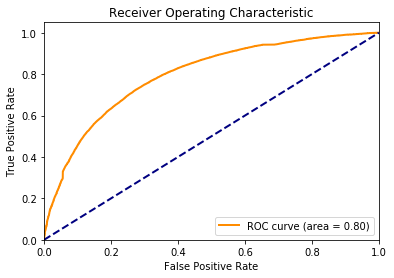

In [31]:
result = pd.read_csv('kernelsvm_cv_rlt.csv')
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_kernel = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['kernel']
best_gamma = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['gamma']

clf = svm.SVC(C=best_c, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma=best_gamma, kernel=best_kernel,
          max_iter=-1, probability=False, random_state=123, shrinking=True,
          tol=0.001, verbose=False)

clf.fit(X_train_new, y_train_new)

preds = clf.predict(X_train_new)
probs = clf.decision_function(X_train_new)

# plot ROC curve
y_score = probs
fpr, tpr, thresholds = roc_curve(y_train_new, y_score)
auc = roc_auc_score(y_train_new, probs)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Summary

Choose the final model which has the highest average cross validation accuracy - LightGBM

In [33]:
def read_cv_results(filename):
    result = pd.read_csv(filename)
    best_score = result.best_score_.values[0]
    return best_score

cv_RFT = read_cv_results('randomforest_cv_rlt.csv')
cv_XGB = read_cv_results('xgboost_cv_rlt.csv')
cv_LGB = read_cv_results('lightgbm_cv_rlt.csv')
cv_LGI = read_cv_results('logistic_cv_rlt.csv')
cv_KNN = read_cv_results('knn_cv_rlt.csv')
cv_SVM = read_cv_results('kernelsvm_cv_rlt.csv')  
print(f"Average Cross Validation Accuracy for RandomForest, XGboost, LightGBM, KNN are: {cv_RFT:.4f}, {cv_XGB:.4f}, {cv_LGB:.4f}, {cv_LGI:.4f}, {cv_KNN:.4f}, {cv_SVM:.4f}")
all_scores = [cv_RFT, cv_XGB, cv_LGB, cv_LGI, cv_KNN, cv_SVM]
modelnames = ['RandomForest','XGboost','LightGBM','Logistic','KNN','SVM']
print("Best model is: ", modelnames[max(enumerate(all_scores),key=(lambda x: x[1]))[0]])


Average Cross Validation Accuracy for RandomForest, XGboost, LightGBM, KNN are: 0.6811, 0.7074, 0.7078, 0.6986, 0.5601, 0.6917
Best model is:  LightGBM


Read in the performance metrics on the entire training data for each model.

In [34]:
def read_metrics_file(filename):
    metrics = pd.read_csv(filename)
    accuracy = metrics['accuracy'].values[0]
    auc = metrics['auc'].values[0]
    f1_0 = ast.literal_eval(metrics['class_0'].values[0])['f1-score']
    f1_1 = ast.literal_eval(metrics['class_1'].values[0])['f1-score']
    return [accuracy, auc, f1_0, f1_1]

RFT = read_metrics_file('randomforest_metrics.csv')
XGB = read_metrics_file('xgboost_metrics.csv')
LGB = read_metrics_file('lightgbm_metrics.csv')
LGI = read_metrics_file('logistic_metrics.csv')
KNN = read_metrics_file('knn_metrics.csv')
SVM = read_metrics_file('kernelsvm_metrics.csv')

Table below summarizes the entire training performance metrics for each of the models we built. 

In [35]:
training_model_summary = {'RandomForest': {'Accuracy': RFT[0], 'AUC': RFT[1], 'F1-0': RFT[2], 'F1-1': RFT[3]}, 
                 'XGboost': {'Accuracy': XGB[0], 'AUC': XGB[1], 'F1-0': XGB[2], 'F1-1': XGB[3]},
                 'LightGBM': {'Accuracy': LGB[0], 'AUC': LGB[1], 'F1-0': LGB[2], 'F1-1': LGB[3]},
                 'Logistic': {'Accuracy': LGI[0], 'AUC': LGI[1], 'F1-0': LGI[2], 'F1-1': LGI[3]},
                 'KNN': {'Accuracy': KNN[0], 'AUC': KNN[1], 'F1-0': KNN[2], 'F1-1': KNN[3]},
                 'SVM': {'Accuracy': SVM[0], 'AUC': SVM[1], 'F1-0': SVM[2], 'F1-1': SVM[3]}
                }
training_model_summary = pd.DataFrame(training_model_summary)
display(training_model_summary)

,RandomForest,XGboost,LightGBM,Logistic,KNN,SVM
AUC,0.769773,0.816779,0.824474,0.772114,0.690565,0.796507
Accuracy,0.701733,0.740829,0.746500,0.704743,0.639459,0.723719
F1-0,0.711575,0.745164,0.750459,0.709972,0.645559,0.728047
F1-1,0.691197,0.736344,0.742412,0.699321,0.633145,0.719250
